# マルチメディア処理入門 第13回

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/schwalbe1996/multimedia_intro/blob/main/notebook13.ipynb)

Google Colabで試したい場合は、上のボタンをクリックして、「ドライブにコピー」を実行してください。（ドライブにコピーしないとコードを変更しても保存できません）

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import cm
import mpl_toolkits.axes_grid1
import cv2
import numpy as np

## 画像表示用の関数

In [2]:
def show_image(image, cmap = cm.gray):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)
    if image.ndim == 3:
        im = ax.imshow(image[:,:,::-1])
    elif image.ndim == 2:
        im = ax.imshow(image, cmap=cmap)
        divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
        cax = divider.append_axes('right','3%', pad='2%')
        fig.colorbar(im, cax=cax)
        
def show_decomposed_images(image, image3, cmap=cm.gray, title=(None,None,None,None)):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(221, title=title[0])
    ax2 = fig.add_subplot(222, title=title[1])        
    ax3 = fig.add_subplot(223, title=title[2])
    ax4 = fig.add_subplot(224, title=title[3])
    im1 = ax1.imshow(image[:,:,::-1])
    im2 = ax2.imshow(image3[:,:,0], cmap=cmap)
    im3 = ax3.imshow(image3[:,:,1], cmap=cmap)
    im4 = ax4.imshow(image3[:,:,2], cmap=cmap)
    plt.colorbar(im2,ax=ax2)
    plt.colorbar(im3,ax=ax3)
    plt.colorbar(im4,ax=ax4)
    plt.show()

## 画像ファイルの読み込み
- このノートブックと同じフォルダに画像ファイル(sudoku.png)を置いてください。
- 今日もモノクロ画像として扱います

In [ ]:
# colabユーザだけここを実行
!wget https://github.com/schwalbe1996/multimedia_intro/raw/main/sudoku.png

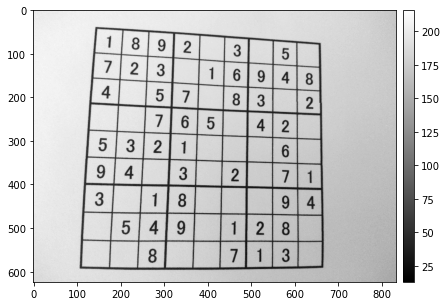

In [3]:
image = cv2.imread("sudoku.png",0)
show_image(image)

# ヒストグラムの描画

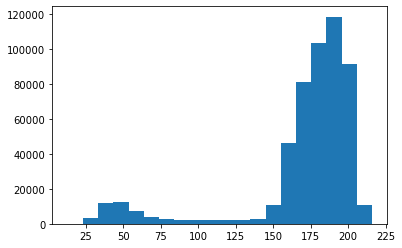

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
# 画像 (image) は 2 次元配列なので、flatten() を使って 1 次元配列に reshape してからヒストグラムを作ります。
h = ax.hist(image.flatten(), bins=20)
plt.show()                     

# 単純閾値処理

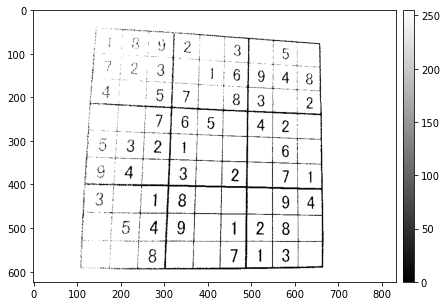

In [5]:
threshold = 50
ret, result = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY) # 画像データ、閾値、255（固定)、cv2.THRESH_BINARY を指定する
show_image(result)

# pタイル法

閾値=133.0


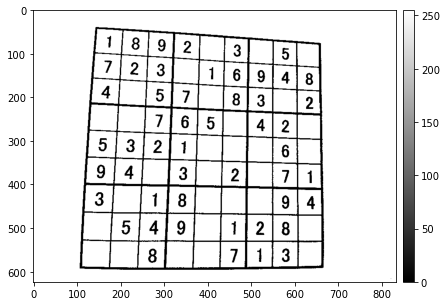

In [6]:
p = 10
threshold = np.percentile(image.flatten(), p)
print (f"閾値={threshold}")
ret, result = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
show_image(result)


# 大津の方法

閾値=120.0


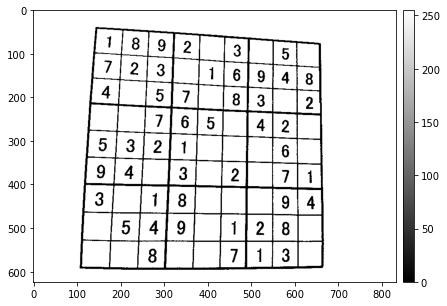

In [7]:
# 閾値を 0、cv2.THRESH_BINARY の代わりに cv2.THRESH_BINARY+cv2.THRESH_OTSU を指定する
ret, result = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print (f"閾値={ret}")
show_image(result)

# クラスタリング
## 本日の画像（その2）

In [ ]:
# colabユーザだけここを実行
!wget https://github.com/schwalbe1996/multimedia_intro/raw/main/choco.png

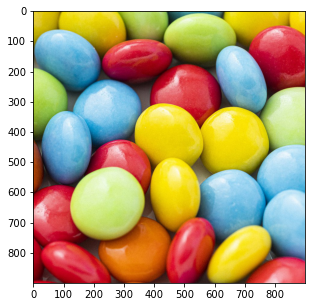

In [8]:
image = cv2.imread("choco.png")
show_image(image)

# 色空間の変換
- BGR⇒HSVに変換します。

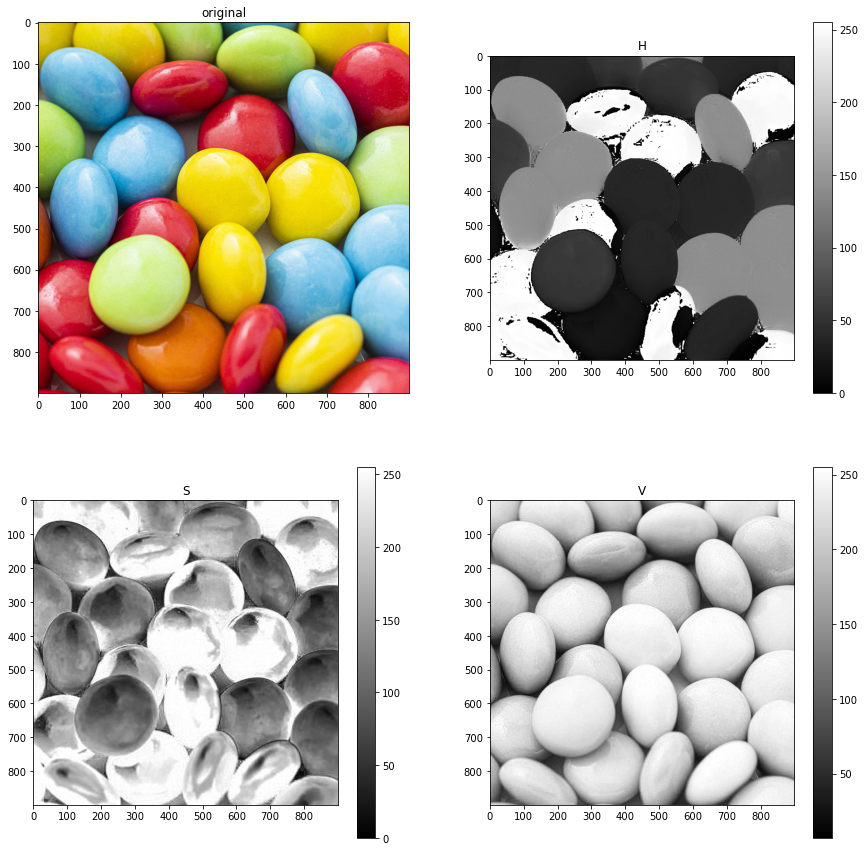

In [9]:
image_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV_FULL)
show_decomposed_images(image, image_HSV, title=("original","H","S","V"))

## （おまけ）HSV の空間で散布図を作ってみる

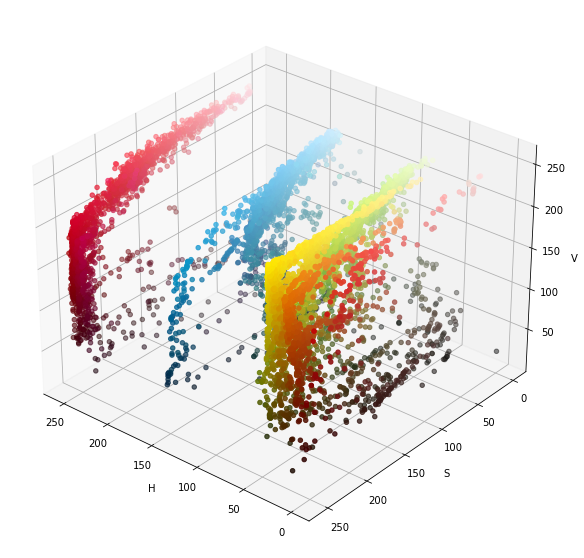

In [10]:
# H,S,V それぞれを 1 次元配列に整形する
H = image_HSV[:,:,0].flatten()
S = image_HSV[:,:,1].flatten()
V = image_HSV[:,:,2].flatten()
# 散布図用の色データ。RGB の順で 0～1 の範囲に収めておく必要があるので 255 で割ってます
c = image.reshape((-1,3))/255
c = c[:,::-1]

# 点の数が多すぎるので 1/100 に間引きます
H = H[::100]
S = S[::100]
V = V[::100]
c = c[::100]
# 3 次元散布図
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
ax.view_init(elev=30, azim=130)
sc = ax.scatter(H, S, V, c=c)
ax.set_xlabel("H")
ax.set_ylabel("S")
ax.set_zlabel("V")
plt.show()

# K-meansクラスタリング

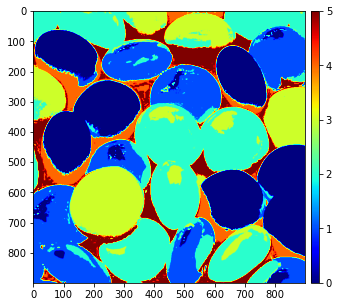

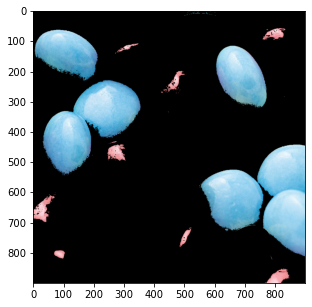

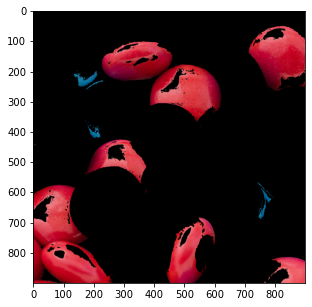

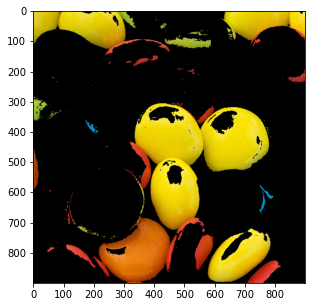

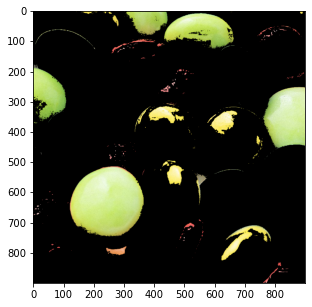

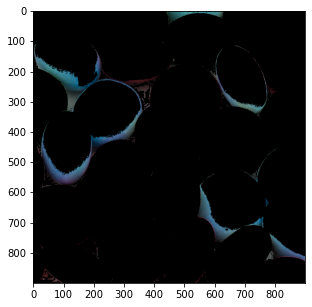

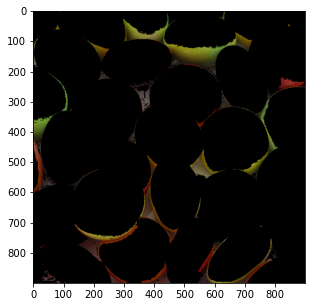

In [11]:
# HSV 空間の画像データを、 (ピクセル数, 3) の 2 次元配列に並び替えます（ついでに小数点付き数字に変換）
Z = image_HSV.reshape((-1,3)).astype(np.float32)
# K-means の終了条件の設定
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# クラスタ数はここで設定します。
K = 6
# K-means クラスタリング本体 乱数によって結果が変わるので itr=10 回 K-means を繰り返して良さげな結果を選ぶ
itr=10
ret,label,center=cv2.kmeans(Z,K,None,criteria,itr,cv2.KMEANS_RANDOM_CENTERS)
label = label.reshape(image.shape[:-1])
# label の各ピクセルには 領域番号を表す 0～K-1 の値が入ってます。
show_image(label,cmap=cm.jet)
for n in range(K):
    disp = np.zeros_like(image)
    disp[label==n] = image[label==n]
    show_image(disp)